Copyright by Arjun Sarkar Research Group Applied Systems Biology - Head: Prof. Dr. Marc Thilo Figge https://www.leibniz-hki.de/en/applied-systems-biology.html HKI-Center for Systems Biology of Infection Leibniz Institute for Natural Product Research and Infection Biology - Hans Knöll Insitute (HKI) Adolf-Reichwein-Straße 23, 07745 Jena, Germany

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import math
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
import datetime

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB5, preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

from sklearn.model_selection import train_test_split

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

strategy = tf.distribute.MirroredStrategy(["GPU:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
df = pd.read_csv('Label_Patches_Training.csv')
df.head()

,video_num,filename,patch_name,infection,patient,class_label,image_path
0,1,246,246_0_0.tif,ca,1,0,/asbdata/Arjun/Bloodi/Patches/1/246_0_0.tif
1,1,246,246_0_1.tif,ca,1,0,/asbdata/Arjun/Bloodi/Patches/1/246_0_1.tif
2,1,246,246_1_0.tif,ca,1,0,/asbdata/Arjun/Bloodi/Patches/1/246_1_0.tif
3,1,246,246_1_1.tif,ca,1,0,/asbdata/Arjun/Bloodi/Patches/1/246_1_1.tif
4,1,94,094_0_0.tif,ca,1,0,/asbdata/Arjun/Bloodi/Patches/1/094_0_0.tif


In [4]:
test = df[(df['patient']==12)]
test

,video_num,filename,patch_name,infection,patient,class_label,image_path
24960,33,246,246_0_0.tif,ca,12,0,/asbdata/Arjun/Bloodi/Patches/33/246_0_0.tif
24961,33,246,246_0_1.tif,ca,12,0,/asbdata/Arjun/Bloodi/Patches/33/246_0_1.tif
24962,33,246,246_1_0.tif,ca,12,0,/asbdata/Arjun/Bloodi/Patches/33/246_1_0.tif
24963,33,246,246_1_1.tif,ca,12,0,/asbdata/Arjun/Bloodi/Patches/33/246_1_1.tif
24964,33,94,094_0_0.tif,ca,12,0,/asbdata/Arjun/Bloodi/Patches/33/094_0_0.tif
...,...,...,...,...,...,...,...
28075,35,250,250_1_1.tif,mock,12,2,/asbdata/Arjun/Bloodi/Patches/35/250_1_1.tif
28076,35,227,227_0_0.tif,mock,12,2,/asbdata/Arjun/Bloodi/Patches/35/227_0_0.tif
28077,35,227,227_0_1.tif,mock,12,2,/asbdata/Arjun/Bloodi/Patches/35/227_0_1.tif
28078,35,227,227_1_0.tif,mock,12,2,/asbdata/Arjun/Bloodi/Patches/35/227_1_0.tif


In [5]:
Xtrain = pd.concat([df, test]).drop_duplicates(keep=False)
Xtrain

,video_num,filename,patch_name,infection,patient,class_label,image_path
0,1,246,246_0_0.tif,ca,1,0,/asbdata/Arjun/Bloodi/Patches/1/246_0_0.tif
1,1,246,246_0_1.tif,ca,1,0,/asbdata/Arjun/Bloodi/Patches/1/246_0_1.tif
2,1,246,246_1_0.tif,ca,1,0,/asbdata/Arjun/Bloodi/Patches/1/246_1_0.tif
3,1,246,246_1_1.tif,ca,1,0,/asbdata/Arjun/Bloodi/Patches/1/246_1_1.tif
4,1,94,094_0_0.tif,ca,1,0,/asbdata/Arjun/Bloodi/Patches/1/094_0_0.tif
...,...,...,...,...,...,...,...
24955,32,250,250_1_1.tif,mock,11,2,/asbdata/Arjun/Bloodi/Patches/32/250_1_1.tif
24956,32,227,227_0_0.tif,mock,11,2,/asbdata/Arjun/Bloodi/Patches/32/227_0_0.tif
24957,32,227,227_0_1.tif,mock,11,2,/asbdata/Arjun/Bloodi/Patches/32/227_0_1.tif
24958,32,227,227_1_0.tif,mock,11,2,/asbdata/Arjun/Bloodi/Patches/32/227_1_0.tif


In [6]:
train, val = train_test_split(Xtrain, test_size=0.2, stratify = Xtrain['class_label'], random_state=42)
train

,video_num,filename,patch_name,infection,patient,class_label,image_path
19565,27,157,157_0_1.tif,ca,10,0,/asbdata/Arjun/Bloodi/Patches/27/157_0_1.tif
7263,13,177,177_1_1.tif,ca,5,0,/asbdata/Arjun/Bloodi/Patches/13/177_1_1.tif
23688,31,194,194_0_0.tif,cg,11,1,/asbdata/Arjun/Bloodi/Patches/31/194_0_0.tif
16078,24,147,147_1_0.tif,ca,9,0,/asbdata/Arjun/Bloodi/Patches/24/147_1_0.tif
8813,15,241,241_0_1.tif,mock,5,2,/asbdata/Arjun/Bloodi/Patches/15/241_0_1.tif
...,...,...,...,...,...,...,...
2834,3,103,103_1_0.tif,mock,1,2,/asbdata/Arjun/Bloodi/Patches/3/103_1_0.tif
14519,22,143,143_1_1.tif,cg,8,1,/asbdata/Arjun/Bloodi/Patches/22/143_1_1.tif
20049,28,181,181_0_1.tif,cg,10,1,/asbdata/Arjun/Bloodi/Patches/28/181_0_1.tif
21941,30,160,160_0_1.tif,ca,11,0,/asbdata/Arjun/Bloodi/Patches/30/160_0_1.tif


In [7]:
val

,video_num,filename,patch_name,infection,patient,class_label,image_path
11083,19,239,239_1_1.tif,cg,7,1,/asbdata/Arjun/Bloodi/Patches/19/239_1_1.tif
2616,3,75,075_0_0.tif,mock,1,2,/asbdata/Arjun/Bloodi/Patches/3/075_0_0.tif
11285,19,195,195_0_1.tif,cg,7,1,/asbdata/Arjun/Bloodi/Patches/19/195_0_1.tif
10015,18,248,248_1_1.tif,ca,7,0,/asbdata/Arjun/Bloodi/Patches/18/248_1_1.tif
7408,14,226,226_0_0.tif,cg,5,1,/asbdata/Arjun/Bloodi/Patches/14/226_0_0.tif
...,...,...,...,...,...,...,...
1411,2,44,044_1_1.tif,cg,1,1,/asbdata/Arjun/Bloodi/Patches/2/044_1_1.tif
19559,27,119,119_1_1.tif,ca,10,0,/asbdata/Arjun/Bloodi/Patches/27/119_1_1.tif
14276,22,220,220_0_0.tif,cg,8,1,/asbdata/Arjun/Bloodi/Patches/22/220_0_0.tif
13926,22,126,126_1_0.tif,cg,8,1,/asbdata/Arjun/Bloodi/Patches/22/126_1_0.tif


<AxesSubplot: xlabel='infection', ylabel='count'>

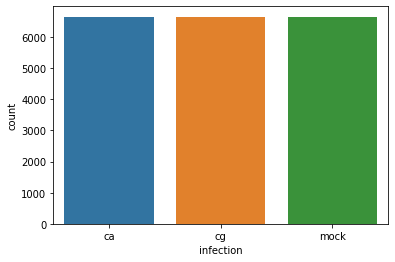

In [8]:
sns.countplot(x='infection',data=train)

<AxesSubplot: xlabel='infection', ylabel='count'>

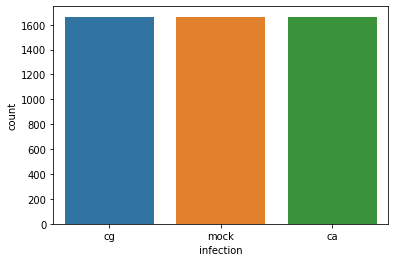

In [9]:
sns.countplot(x='infection',data=val)

<AxesSubplot: xlabel='infection', ylabel='count'>

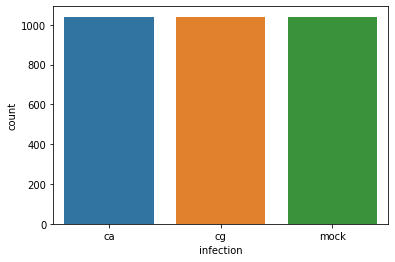

In [10]:
sns.countplot(x='infection',data=test)

In [11]:
image_size = 512
batch_size = 16

def get_train_generator(df, x_col, y_cols, shuffle=True, batch_size=batch_size, seed=1, image_size=image_size):

    # normalize images
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        horizontal_flip=True,
                                        vertical_flip=True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size=(image_size,image_size),
            shuffle=False,
            seed=seed)
    
    return generator

def get_test_and_valid_generator(valid_df, test_df, x_col, y_cols, batch_size=batch_size, seed=1, image_size=image_size):

    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size = (image_size,image_size),
            shuffle=False,
            seed=seed)
    
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size = (image_size,image_size),
            shuffle=False,
            seed=seed)
    
    return valid_generator, test_generator

In [12]:
train_generator = get_train_generator(train, 'image_path', 'class_label')
valid_generator, test_generator= get_test_and_valid_generator(val, test, 'image_path','class_label')

Found 19968 validated image filenames.
Found 4992 validated image filenames.
Found 3120 validated image filenames.


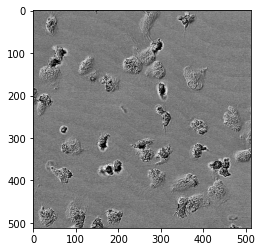

In [13]:
x, y = train_generator.__getitem__(3)
plt.imshow((x[0]* 255).astype(np.uint8))
plt.show()

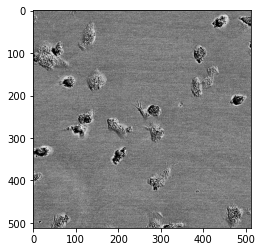

In [14]:
x, y = valid_generator.__getitem__(3)
plt.imshow((x[0]* 255).astype(np.uint8))
plt.show()

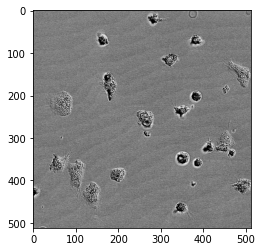

In [15]:
x, y = test_generator.__getitem__(3)
plt.imshow((x[0]* 255).astype(np.uint8))
plt.show()

In [16]:
with strategy.scope():
    
    inputs = Input(shape=(image_size,image_size, 3))
    base_model = EfficientNetB5 (weights = 'imagenet',include_top=False, input_tensor=inputs)

    # add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(base_model.output)

    x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
    x = Dropout(0.5)(x)

    # and a logistic layer
    predictions = Dense(3, activation="softmax")(x)
    
    model = Model(inputs=inputs, outputs=predictions)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 512, 512, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 512, 512, 3)  0           ['normalization[0][0]']      

 block1c_dwconv (DepthwiseConv2  (None, 256, 256, 24  216        ['block1b_add[0][0]']            
 D)                             )                                                                 
                                                                                                  
 block1c_bn (BatchNormalization  (None, 256, 256, 24  96         ['block1c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block1c_activation (Activation  (None, 256, 256, 24  0          ['block1c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 24)          0           ['block1c_activation[0][0]']     
 agePoolin

                                                                                                  
 block2b_bn (BatchNormalization  (None, 128, 128, 24  960        ['block2b_dwconv[0][0]']         
 )                              0)                                                                
                                                                                                  
 block2b_activation (Activation  (None, 128, 128, 24  0          ['block2b_bn[0][0]']             
 )                              0)                                                                
                                                                                                  
 block2b_se_squeeze (GlobalAver  (None, 240)         0           ['block2b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2b_s

 D)                             0)                               ']                               
                                                                                                  
 block2d_bn (BatchNormalization  (None, 128, 128, 24  960        ['block2d_dwconv[0][0]']         
 )                              0)                                                                
                                                                                                  
 block2d_activation (Activation  (None, 128, 128, 24  0          ['block2d_bn[0][0]']             
 )                              0)                                                                
                                                                                                  
 block2d_se_squeeze (GlobalAver  (None, 240)         0           ['block2d_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block3a_dwconv_pad (ZeroPaddin  (None, 131, 131, 24  0          ['block3a_expand_activation[0][0]
 g2D)                           0)                               ']                               
                                                                                                  
 block3a_dwconv (DepthwiseConv2  (None, 64, 64, 240)  6000       ['block3a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block3a_bn (BatchNormalization  (None, 64, 64, 240)  960        ['block3a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3a_activation (Activation  (None, 64, 64, 240)  0          ['block3a_bn[0][0]']             
 )        

 )                                                                                                
                                                                                                  
 block3c_se_squeeze (GlobalAver  (None, 384)         0           ['block3c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3c_se_reshape (Reshape)   (None, 1, 1, 384)    0           ['block3c_se_squeeze[0][0]']     
                                                                                                  
 block3c_se_reduce (Conv2D)     (None, 1, 1, 16)     6160        ['block3c_se_reshape[0][0]']     
                                                                                                  
 block3c_se_expand (Conv2D)     (None, 1, 1, 384)    6528        ['block3c_se_reduce[0][0]']      
          

 block3e_se_reshape (Reshape)   (None, 1, 1, 384)    0           ['block3e_se_squeeze[0][0]']     
                                                                                                  
 block3e_se_reduce (Conv2D)     (None, 1, 1, 16)     6160        ['block3e_se_reshape[0][0]']     
                                                                                                  
 block3e_se_expand (Conv2D)     (None, 1, 1, 384)    6528        ['block3e_se_reduce[0][0]']      
                                                                                                  
 block3e_se_excite (Multiply)   (None, 64, 64, 384)  0           ['block3e_activation[0][0]',     
                                                                  'block3e_se_expand[0][0]']      
                                                                                                  
 block3e_project_conv (Conv2D)  (None, 64, 64, 64)   24576       ['block3e_se_excite[0][0]']      
          

                                                                  'block4b_se_expand[0][0]']      
                                                                                                  
 block4b_project_conv (Conv2D)  (None, 32, 32, 128)  98304       ['block4b_se_excite[0][0]']      
                                                                                                  
 block4b_project_bn (BatchNorma  (None, 32, 32, 128)  512        ['block4b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_drop (Dropout)         (None, 32, 32, 128)  0           ['block4b_project_bn[0][0]']     
                                                                                                  
 block4b_add (Add)              (None, 32, 32, 128)  0           ['block4b_drop[0][0]',           
          

 lization)                                                                                        
                                                                                                  
 block4d_drop (Dropout)         (None, 32, 32, 128)  0           ['block4d_project_bn[0][0]']     
                                                                                                  
 block4d_add (Add)              (None, 32, 32, 128)  0           ['block4d_drop[0][0]',           
                                                                  'block4c_add[0][0]']            
                                                                                                  
 block4e_expand_conv (Conv2D)   (None, 32, 32, 768)  98304       ['block4d_add[0][0]']            
                                                                                                  
 block4e_expand_bn (BatchNormal  (None, 32, 32, 768)  3072       ['block4e_expand_conv[0][0]']    
 ization) 

                                                                  'block4e_add[0][0]']            
                                                                                                  
 block4g_expand_conv (Conv2D)   (None, 32, 32, 768)  98304       ['block4f_add[0][0]']            
                                                                                                  
 block4g_expand_bn (BatchNormal  (None, 32, 32, 768)  3072       ['block4g_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4g_expand_activation (Act  (None, 32, 32, 768)  0          ['block4g_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4g_d

                                                                                                  
 block5b_dwconv (DepthwiseConv2  (None, 32, 32, 1056  26400      ['block5b_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 32, 32, 1056  4224       ['block5b_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block5b_activation (Activation  (None, 32, 32, 1056  0          ['block5b_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5b_s

                                                                                                  
 block5d_bn (BatchNormalization  (None, 32, 32, 1056  4224       ['block5d_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block5d_activation (Activation  (None, 32, 32, 1056  0          ['block5d_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 1056)        0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_s

                                                                                                  
 block5f_activation (Activation  (None, 32, 32, 1056  0          ['block5f_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5f_se_squeeze (GlobalAver  (None, 1056)        0           ['block5f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5f_se_reshape (Reshape)   (None, 1, 1, 1056)   0           ['block5f_se_squeeze[0][0]']     
                                                                                                  
 block5f_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block5f_se_reshape[0][0]']     
          

                                                                                                  
 block6a_activation (Activation  (None, 16, 16, 1056  0          ['block6a_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block6a_se_squeeze (GlobalAver  (None, 1056)        0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 1056)   0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block6a_se_reshape[0][0]']     
          

                                                                                                  
 block6c_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6c_se_reshape[0][0]']     
                                                                                                  
 block6c_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6c_se_reduce[0][0]']      
                                                                                                  
 block6c_se_excite (Multiply)   (None, 16, 16, 1824  0           ['block6c_activation[0][0]',     
                                )                                 'block6c_se_expand[0][0]']      
                                                                                                  
 block6c_project_conv (Conv2D)  (None, 16, 16, 304)  554496      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_p

 block6e_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6e_se_reduce[0][0]']      
                                                                                                  
 block6e_se_excite (Multiply)   (None, 16, 16, 1824  0           ['block6e_activation[0][0]',     
                                )                                 'block6e_se_expand[0][0]']      
                                                                                                  
 block6e_project_conv (Conv2D)  (None, 16, 16, 304)  554496      ['block6e_se_excite[0][0]']      
                                                                                                  
 block6e_project_bn (BatchNorma  (None, 16, 16, 304)  1216       ['block6e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6e_d

                                )                                 'block6g_se_expand[0][0]']      
                                                                                                  
 block6g_project_conv (Conv2D)  (None, 16, 16, 304)  554496      ['block6g_se_excite[0][0]']      
                                                                                                  
 block6g_project_bn (BatchNorma  (None, 16, 16, 304)  1216       ['block6g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6g_drop (Dropout)         (None, 16, 16, 304)  0           ['block6g_project_bn[0][0]']     
                                                                                                  
 block6g_add (Add)              (None, 16, 16, 304)  0           ['block6g_drop[0][0]',           
          

                                                                                                  
 block6i_project_bn (BatchNorma  (None, 16, 16, 304)  1216       ['block6i_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6i_drop (Dropout)         (None, 16, 16, 304)  0           ['block6i_project_bn[0][0]']     
                                                                                                  
 block6i_add (Add)              (None, 16, 16, 304)  0           ['block6i_drop[0][0]',           
                                                                  'block6h_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 16, 16, 1824  554496      ['block6i_add[0][0]']            
          

                                                                                                  
 block7c_expand_conv (Conv2D)   (None, 16, 16, 3072  1572864     ['block7b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block7c_expand_bn (BatchNormal  (None, 16, 16, 3072  12288      ['block7c_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block7c_expand_activation (Act  (None, 16, 16, 3072  0          ['block7c_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block7c_d

In [18]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

stopping = EarlyStopping(monitor='val_loss', patience=4)

callbacks = ModelCheckpoint('eff_patches_test_9.h5', 
                            monitor='val_loss', save_best_only=True, mode = 'auto')

In [19]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              epochs = 6,
                              callbacks = [callbacks,lr_schedule,stopping])

Epoch 1/6
1248/1248 [==============================] - 1647s 1s/step - loss: 0.3512 - accuracy: 0.9301 - val_loss: 0.2192 - val_accuracy: 0.9411 - lr: 0.0010
Epoch 2/6
1248/1248 [==============================] - 1683s 1s/step - loss: 0.1092 - accuracy: 0.9746 - val_loss: 0.0291 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 3/6
1248/1248 [==============================] - 1646s 1s/step - loss: 0.0795 - accuracy: 0.9826 - val_loss: 0.0531 - val_accuracy: 0.9872 - lr: 0.0010
Epoch 4/6
1248/1248 [==============================] - 1637s 1s/step - loss: 0.0647 - accuracy: 0.9857 - val_loss: 0.0264 - val_accuracy: 0.9984 - lr: 0.0010
Epoch 5/6
1248/1248 [==============================] - 1639s 1s/step - loss: 0.0681 - accuracy: 0.9852 - val_loss: 0.1210 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 6/6
1248/1248 [==============================] - 1643s 1s/step - loss: 0.0456 - accuracy: 0.9917 - val_loss: 0.0221 - val_accuracy: 0.9968 - lr: 0.0010


In [20]:
final_model = tf.keras.models.load_model('eff_patches_test_9.h5')

In [21]:
predicted = final_model.predict(test_generator, steps = len(test_generator)).argmax(axis=1)
predicted

195/195 [==============================] - 24s 110ms/step


array([0, 0, 2, ..., 2, 2, 2])

In [22]:
test_labels = test['class_label']
test_labels = np.array(test_labels)
test_labels

array([0, 0, 0, ..., 2, 2, 2])

In [23]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

([<matplotlib.axis.YTick at 0x7f0460524460>,
 [Text(0, 0, 'ca'), Text(0, 1, 'cg'), Text(0, 2, 'mock')])

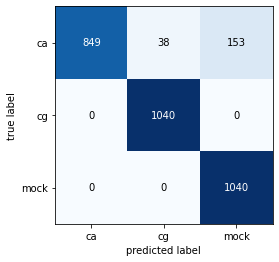

In [24]:
labels = ['ca','cg','mock']

matrix = confusion_matrix (test_labels,predicted)
plot_confusion_matrix(matrix, figsize=(4,4))
plt.xticks(range(3),labels, fontsize=10)
plt.yticks(range(3),labels, fontsize=10)